For 75% of states, the median home price in 1990 was \\$ 57.4k or greater. Therefore, it would've have been difficult to find a good home around \\$ 50k in most states, and that means our assumption from earlier may not be realistic.

In [1]:
import numpy as np
import pandas as pd
from os import listdir
from datetime import timedelta
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from sklearn import linear_model

#create a dataFrame from each file
mortgage_rates=pd.read_csv("MORTGAGE30US.csv",index_col=0)
mortgage_rates.index=pd.to_datetime(mortgage_rates.index)
US_median_price=pd.read_csv("US_median_home_price.csv",index_col=0)
US_median_price.index=pd.to_datetime(US_median_price.index)

#csv file has 5 columns. we only need the Open price
SP500_df=pd.read_csv('HistoricalPrices.csv',index_col=0,usecols=[0,1])
SP500_df.index=pd.to_datetime(SP500_df.index)
#sort chronologically, every business day is included
SP500_df.sort_index(inplace=True) 

#take average of each quarter to compare with the housing price index
SP500_q=SP500_df.resample('QS').mean()
#normalize to 1980 Q1, same as house price index
SP500_q=SP500_q/SP500_q[SP500_q.index==datetime(1980,1,1)].values

#load the csv files of the states
files=listdir("states/")
frames=[]
for f in files:
    #load the csv into a DataFrame
    frames.append(pd.read_csv('states/'+f,index_col=0))
#combine all frames into a single frame. 1980 Q1 is set to 1
states_HPI=frames[0].join(frames[1:])/100
#dates are the first day of each quarter
states_HPI.index=pd.to_datetime(states_HPI.index)
#rename all the state names without the HPI
#create a dict where the keys are the column names and the values are just the state abbrev
mapping={}
for state in states_HPI.columns:
    mapping[state]=state[:2]
states_HPI.rename(columns=mapping,inplace=True)
#create a new frame with all data as columns
df=SP500_q.join(states_HPI,how='inner')
#rename the column for clarity
df.rename(columns={' Open': 'S&P 500'},inplace=True)

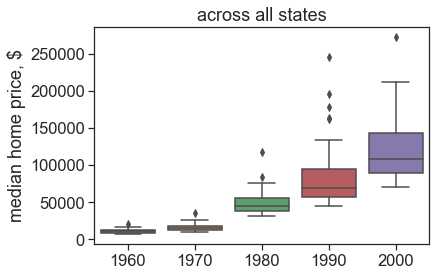

In [2]:
median_home=pd.read_csv("https://www2.census.gov/programs-surveys/decennial/tables/time-series/coh-values/values-unadj.txt",
                        header=None,skiprows=4,skipfooter=3,engine='python',sep='$',usecols=range(6))
median_home.columns=['state','2000','1990','1980','1970','1960']
#re-order the columns
median_home=median_home.reindex(columns=['state','1960','1970','1980','1990','2000'])
for col in median_home.columns[1:]:
    #remove commas and convert to numbers
    median_home[col]=pd.to_numeric(median_home[col].str.replace(",",""))
#first row is for United states and we will drop it during the merge
median_home['for_merge']=np.arange(len(median_home))-1
#add columns of abbreviations and state names that don't have space fillers
frame=pd.read_csv('state_abbrev.csv')
median_home=pd.merge(frame,median_home,left_index=True,right_on='for_merge')
median_home.drop(['state','for_merge'],axis='columns',inplace=True)
#median_home.describe()

sns.boxplot(data=median_home)
plt.ylabel('median home price, $')
plt.title('across all states')
plt.show()

In [3]:
#initial investment
principal=10000 #$10k

def calc_mortgage(mortgage_rates,start_date,downpayment,final_date):
    """ Calculates the total cost of a mortgage
    Assumes that the mortage is for 30 years at a fixed interest rate.
    INPUT
    mortgage_rates: DataFrame of interest rates which are not fractional, but are percentages multiplied by 100
    start_date: datetime object
    downpayment: downpayment for home purchase
    """
    #determine the average interest rate on a fixed, 30-year loan at the purchase time
    int_rate=mortgage_rates['MORTGAGE30US'][mortgage_rates.index>=start_date]
    r=int_rate[0]/12/100 #monthly interest rate
    N_total=30*12 # number of monthly payments
    #assume the principal investment is 20% of the home price
    house_price=5*downpayment
    #calculate the initial value of the loan
    loan_principal=house_price-downpayment
    #calculate the monthly mortgage payment
    cost=loan_principal*r/(1-(1 + r)**(-N_total))
    #how many months have passed?
    N_elapsed=(final_date.year-start_date.year)*12 + final_date.month-start_date.month
    #calculate the total cost of the mortgage
    cost=cost*np.array([N_total, N_elapsed])
    return cost, house_price

cost, house_price=calc_mortgage(mortgage_rates,start_date,principal,final_date)


NameError: name 'start_date' is not defined